# Housekeeping

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
from os import listdir

#### Define output location

In [8]:
cd O:\TUD\GUVs\20220204_Stellaris_cortex-FRAP\analysis\s

O:\TUD\GUVs\20220204_Stellaris_cortex-FRAP\analysis\s


In [3]:
sns.set_context('talk')

#### Define data to load

Metadata for analysis.

In [9]:
df_meta = pd.DataFrame([['20220204_run4_old-ves1', 
                          r'O:\\TUD\\GUVs\\20220204_Stellaris_cortex-FRAP\\analysis\\20220204_run1_Arp-no-ATP-regen\\old-ves-1_FRAP', 
                          'tc_fast', '0',
                          54, 58, 
                          15, 30],
                        ['20220204_run4_old-ves2', 
                          r'O:\\TUD\\GUVs\\20220204_Stellaris_cortex-FRAP\\analysis\\20220204_run1_Arp-no-ATP-regen\\old-ves-2_FRAP', 
                          'tc_fast', '0',
                          56, 64, 
                          10, 20],
                        ['20220204_run4_old-ves3', 
                          r'O:\\TUD\\GUVs\\20220204_Stellaris_cortex-FRAP\\analysis\\20220204_run1_Arp-no-ATP-regen\\old-ves-3_FRAP', 
                          'tc_fast', '0',
                          63, 67, 
                          18, 30],
                        ['20220204_run4_ves3', 
                          r'O:\\TUD\\GUVs\\20220204_Stellaris_cortex-FRAP\\analysis\\20220204_run1_Arp-no-ATP-regen\\ves3', 
                          'tc_fast', '0',
                          64, 69, 
                          5, 20],
                        ['20220204_run4_ves4', 
                          r'O:\\TUD\\GUVs\\20220204_Stellaris_cortex-FRAP\\analysis\\20220204_run1_Arp-no-ATP-regen\\ves4', 
                          'tc_fast', '0',
                          39, 44, 
                          5, 20],
                        ['20220204_run4_ves5', 
                          r'O:\\TUD\\GUVs\\20220204_Stellaris_cortex-FRAP\\analysis\\20220204_run1_Arp-no-ATP-regen\\ves5', 
                          'tc_fast', '0',
                          30, 35, 
                          5, 15],
                        ['20220204_fascin_ves1', 
                          r'O:\\TUD\\GUVs\\20220204_Stellaris_cortex-FRAP\\analysis\\20220204_fascin\\ves1', 
                          'tc_slow', 'n.a.',
                          3.2, 3.9, 
                          4.5, 5.9]
                        ,
                        ['20220204_run3_ves1', 
                          r'O:\\TUD\\GUVs\\20220204_Stellaris_cortex-FRAP\\analysis\\20220204_run3_Arp-with-regen\\ves1', 
                          'tc_fast', '0',
                          50.7, 55.7, 
                          5, 20],
                        ['20220204_run3_ves2', 
                          r'O:\\TUD\\GUVs\\20220204_Stellaris_cortex-FRAP\\analysis\\20220204_run3_Arp-with-regen\\ves2', 
                          'tc_fast', '1',
                          37, 43, 
                          5, 20],
                        ['20220204_run3_ves3', 
                          r'O:\\TUD\\GUVs\\20220204_Stellaris_cortex-FRAP\\analysis\\20220204_run3_Arp-with-regen\\ves3', 
                          'tc_fast', '1',
                          61, 66.5, 
                          5, 20],
                        ['20220204_run3_ves4', 
                          r'O:\\TUD\\GUVs\\20220204_Stellaris_cortex-FRAP\\analysis\\20220204_run3_Arp-with-regen\\ves4', 
                          'tc_fast', '1',
                          55, 60, 
                          15, 35],
                        ['20220204_run3_ves5', 
                          r'O:\\TUD\\GUVs\\20220204_Stellaris_cortex-FRAP\\analysis\\20220204_run3_Arp-with-regen\\ves5', 
                          'tc_fast', '1',
                          32, 37, 
                          5, 20],
                        ['20220204_run3_ves6', 
                          r'O:\\TUD\\GUVs\\20220204_Stellaris_cortex-FRAP\\analysis\\20220204_run3_Arp-with-regen\\ves6', 
                          'tc_fast', '1',
                          47, 53, 
                          5, 20]
                       ], 
                       columns=['name', 'file loc', 
                                'time course', 'ATP regeneration',
                                'FRAP region start', 'FRAP region end', 
                                'ref region start', 'ref region end'])

Specify timing of FRAP experiments

In [10]:
df_timecourses = pd.DataFrame([['tc_slow', 
                                5, 1.95, 
                                15, 1.95, 
                                25, 5, 
                                10],
                              ['tc_fast', 
                                5, 1.95, 
                                15, 1.95, 
                                25, 3, 
                                5],
                              ],
                              columns=['time course code',
                                         'prebleach last frame', 'prebleach s per frame', 
                                         'postbleach1 last frame', 'postbleach1 s per frame', 
                                         'postbleach2 last frame', 'postbleach2 s per frame', 
                                         'postbleach3 s per frame'])

#### Define commands

In [11]:
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

## Extract FRAP data

In [12]:
# create dataframes in which to save data for all experiments
df_spatial = pd.DataFrame()
df_temporal = pd.DataFrame()

for expno in range(len(df_meta)):

    # create dataframe containing the entire experiment
    df_experiment=pd.DataFrame()
    

    # find and load time resolved data for one experiment
    thefilepath = df_meta['file loc'][expno]
    files = find_csv_filenames( thefilepath )
    for fileno in range(len(files)): 
        file = files[fileno]
        tempdf = pd.read_csv(thefilepath+'\\'+file, skiprows=[0], names=['distance (um)', 'grey value'])
        tempdf['frame']=[fileno]*len(tempdf)
        tempdf['grey rolling']=tempdf['grey value'].rolling(window=3).mean()
        df_experiment = pd.concat([df_experiment, tempdf])



    # translate frames to time
    # look up appropriate time course
    timecourse = df_meta['time course'][expno]
    if timecourse=='tc_slow': 
        stupidindex=0
    elif timecourse=='tc_fast':
        stupidindex=1
    # add time column
    df_experiment['time (s)']=[0]*len(df_experiment)
    # add metadata name column
    df_experiment['experiment']=df_meta['name'][expno]
    df_experiment['ATP regeneration']=df_meta['ATP regeneration'][expno]
    #populate time column
    # pre-bleach
    preb_lastframe = df_timecourses.loc[df_timecourses['time course code']==timecourse,'prebleach last frame'][stupidindex]+1
    preb_spf = df_timecourses.loc[df_timecourses['time course code']==timecourse,'prebleach s per frame'][stupidindex]
    for frame in np.arange(1,preb_lastframe ):
        df_experiment.loc[df_experiment['frame']==frame-1,'time (s)'] = - preb_spf*(preb_lastframe-frame)
    # post-bleach 1
    pb1_lastframe = df_timecourses.loc[df_timecourses['time course code']==timecourse,'postbleach1 last frame'][stupidindex]+1
    pb1_spf = df_timecourses.loc[df_timecourses['time course code']==timecourse,'postbleach1 s per frame'][stupidindex]
    for frame in np.arange(preb_lastframe,pb1_lastframe ):
        df_experiment.loc[df_experiment['frame']==frame,'time (s)'] = pb1_spf*(frame-preb_lastframe)
    # post-bleach 2
    pb2_lastframe = df_timecourses.loc[df_timecourses['time course code']==timecourse,'postbleach2 last frame'][stupidindex]+1
    pb2_spf = df_timecourses.loc[df_timecourses['time course code']==timecourse,'postbleach2 s per frame'][stupidindex]
    for frame in np.arange(pb1_lastframe,pb2_lastframe ):
        df_experiment.loc[
            df_experiment['frame']==frame,'time (s)'] = pb2_spf*(frame+1-pb1_lastframe) + df_experiment.loc[
            df_experiment['frame']==pb1_lastframe-1]['time (s)'][0]
    # post-bleach 3
    pb3_lastframe = df_experiment['frame'].nunique()
    pb3_spf = df_timecourses.loc[df_timecourses['time course code']==timecourse,'postbleach3 s per frame'][stupidindex]
    for frame in np.arange(pb2_lastframe,pb3_lastframe ):
        df_experiment.loc[
            df_experiment['frame']==frame,'time (s)'] = pb3_spf*(frame+1-pb2_lastframe) + df_experiment.loc[
            df_experiment['frame']==pb2_lastframe-1]['time (s)'][0]    




    # FRAP analysis
    # analyze FRAP region over time    
    idx = np.where((
        df_experiment['distance (um)']>df_meta['FRAP region start'][expno]) 
        & (df_experiment['distance (um)']<df_meta['FRAP region end'][expno]))
    df_FRAP = df_experiment.iloc[idx]
    # analyze reference region over time to correct for bleaching of the entire GUV
    idx = np.where((
        df_experiment['distance (um)']>df_meta['ref region start'][expno]) 
        & (df_experiment['distance (um)']<df_meta['ref region end'][expno]))
    df_ref = df_experiment.iloc[idx].groupby('time (s)').mean()['grey rolling']
    df_ref.head()

    # normalize fluorescence per frame
    df_recovery = pd.DataFrame(columns=['experiment','time (s)',
                                        'intensity FRAP', 'sd intensity FRAP',
                                        'intensity ref', 
                                        'FRAP intensity bleach corrected', 'sd intensity corrected'] )
    df_recovery['time (s)']=df_FRAP['time (s)'].unique()
    df_recovery['intensity FRAP']=df_FRAP.groupby('time (s)').mean()['grey rolling'].values
    df_recovery['sd intensity FRAP']=df_FRAP.groupby('time (s)').std()['grey rolling'].values
    df_recovery['intensity ref'] = df_experiment.iloc[idx].groupby('time (s)').mean()['grey rolling'].values
    df_recovery['FRAP intensity bleach corrected'] = df_recovery['intensity FRAP']/df_recovery['intensity ref']
    df_recovery['sd intensity corrected'] = df_recovery['sd intensity FRAP']/df_recovery['intensity ref']
    df_recovery['experiment']=df_meta['name'][expno]
    df_recovery['ATP regeneration']=df_meta['ATP regeneration'][expno]


    df_spatial = pd.concat([df_spatial, df_experiment])
    df_temporal = pd.concat([df_temporal, df_recovery])

#### Save data

In [13]:
cd O:\TUD\GUVs\20220204_Stellaris_cortex-FRAP\analysis\s

O:\TUD\GUVs\20220204_Stellaris_cortex-FRAP\analysis\s


In [14]:
df_meta.to_csv('20220222_FRAP_metadata.csv')
df_spatial.to_csv('20220222_FRAP-data_all_spatiallyreslved.csv')
df_temporal.to_csv('20220222_FRAP-data_all_recovery.csv')

# Plotting

#### Plot all, distinguish fascin

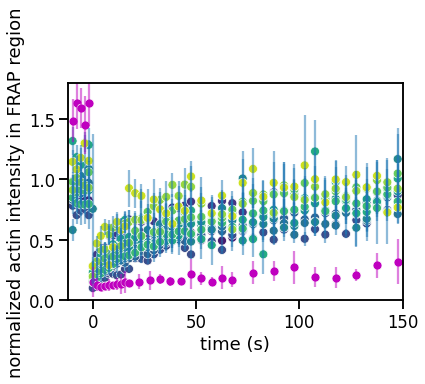

In [16]:
ax=sns.scatterplot(data=df_temporal.loc[df_temporal['experiment']!='20220204_fascin_ves1'], 
                   x='time (s)', y='FRAP intensity bleach corrected', 
                   hue='experiment', palette='viridis')
plt.errorbar(df_temporal.loc[df_temporal['experiment']!='20220204_fascin_ves1']['time (s)'].values, 
             df_temporal.loc[df_temporal['experiment']!='20220204_fascin_ves1']['FRAP intensity bleach corrected'].values, 
             df_temporal.loc[df_temporal['experiment']!='20220204_fascin_ves1']['sd intensity corrected'].values, 
             ls='none', alpha=0.5)#palette='viridis')
ax.set_ylabel('normalized actin intensity in FRAP region')


ax=sns.scatterplot(data=df_temporal.loc[df_temporal['experiment']=='20220204_fascin_ves1'], 
                   x='time (s)', y='FRAP intensity bleach corrected', 
                   color='m')
plt.errorbar(df_temporal.loc[df_temporal['experiment']=='20220204_fascin_ves1']['time (s)'].values, 
             df_temporal.loc[df_temporal['experiment']=='20220204_fascin_ves1']['FRAP intensity bleach corrected'].values, 
             df_temporal.loc[df_temporal['experiment']=='20220204_fascin_ves1']['sd intensity corrected'].values, 
             color='m',
             ls='none', alpha=0.5)
ax.set_ylim(0,1.8)
ax.set_xlim(-12, 150)
#ax.legend(['ves1', 'old-ves1', 'old-ves2', 'old-ves3', 'ves3', 'ves4', 'ves5', 'ves-fascin'])#bbox_to_anchor=(1.05, 1), loc=2 ) 
plt.legend([],[], frameon=False)
plt.savefig('GUV-cortex-FRAPs.png', bbox_inches='tight', dpi=300)

## FRAP data fitting

example code

In [17]:
import numpy as np
import scipy as sp
import pylab as pl
from scipy.optimize.minpack import curve_fit

In [18]:
 df_temporal.loc[df_temporal['time (s)']== 0].mean()['FRAP intensity bleach corrected']

0.23374418535794753

In [19]:
df_fitting = df_temporal.loc[df_temporal['time (s)']>= 0]

Fitting with single exponential recovery

In [20]:
def FRAP_recovery_single(t, Iinf, omega):
    return  Iinf * ( 1 - np.exp(-t*omega) )

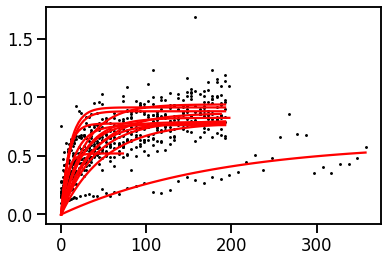

In [21]:
fitparams = pd.DataFrame(columns=['experiment', ])
for ii in range(len(df_fitting['experiment'].unique())):

    exp_tofit = df_fitting['experiment'].unique()[ii]

    x = df_fitting.loc[df_fitting['experiment']==exp_tofit]['time (s)']
    y = df_fitting.loc[df_fitting['experiment']==exp_tofit]['FRAP intensity bleach corrected']

    guess = [1, 0.2]

    c, cov = curve_fit( FRAP_recovery_single, x, y, guess)
    I_pred  =  FRAP_recovery_single(x, c[0], c[1])


    plt.plot(x, I_pred, 'r')
    plt.scatter(x,y, color='k', s=2)

#    print(c)
#    print('R2: ', r2_score(y, I_pred))
    